# Wrapping up ETL with the L

The goal of this jupyter notebook is to show process of uploading data to a database. It's time to load data to AWS S3.

Before we do that though, we're going to extract data from a bulk storage and transform it into a more useful analytical format. Thus, we'll be doing a full ETL pipeline.

The data that we'll be extracting contains daily numbers of Covid-19 positive cases and deaths by each county and state in the US. Most dashboards or reporting metrics are going to want values 'rolled up' into a higher level. We're going to do this in two ways:

* We're going to want aggregate numbers by state. Hearing about high rates in some specific county might matter for some people, but most sources will want state-level numbers.

* We're also going to want to rollup our data into weekly aggregates vs. daily numbers. Daily numbers are problematic as some sources only report on specific days of the week. For example, hospitals might not update their stats on the weekends. Similarly U Arizona doesn't test on the weekends. This means that daily numbers aren't an accurate reflection of the overall trend, while weekly numbers are.

The last thing we'll do is some wrangling to make a unique primary key for each row.

Once that is done *then* we can upload the table to our database.

## Extracting our data from S3

Extracting data in this case is pretty easy. I have this dataset on Amazon S3 which is their bulk simple storage.

We can bring the data in via our usual `pd.read_csv()`. Then we'll do a quick exploration to figure out what we need to do as far as transforms.

In [ ]:
# Get pandas
import pandas as pd

In [ ]:
# We'll call our data 'covid'
covid = pd.read_csv('https://ista322-fall2021.s3.us-west-1.amazonaws.com/covid_daily_cases.csv')

### Quick explore

Let's look at the head, a describe, and shape.

In [ ]:
# head
covid.tail()

,date,state,county_code,county,daily_cases,daily_deaths
625620,10/15/2020,Wyoming,56037,Sweetwater,4,0
625621,10/15/2020,Wyoming,56039,Teton,1,0
625622,10/15/2020,Wyoming,56041,Uinta,3,0
625623,10/15/2020,Wyoming,56043,Washakie,0,0
625624,10/15/2020,Wyoming,56045,Weston,5,0


In [ ]:
covid[covid['state'] == 'Washington']

,date,state,county_code,county,daily_cases,daily_deaths
0,1/22/2020,Washington,53061,Snohomish,0,0
1,1/23/2020,Washington,53061,Snohomish,0,0
2,1/24/2020,Washington,53061,Snohomish,0,0
4,1/25/2020,Washington,53061,Snohomish,0,0
7,1/26/2020,Washington,53061,Snohomish,0,0
...,...,...,...,...,...,...
625470,10/15/2020,Washington,53069,Wahkiakum,1,0
625471,10/15/2020,Washington,53071,Walla Walla,5,0
625472,10/15/2020,Washington,53073,Whatcom,8,0
625473,10/15/2020,Washington,53075,Whitman,33,0


In [ ]:
# describe
covid.describe()

,county_code,daily_cases,daily_deaths
count,625625.000000,625625.000000,625625.000000
mean,31175.358971,12.333928,0.307016
std,16267.627306,67.809433,2.486959
min,1001.000000,-2321.000000,-512.000000
25%,18169.000000,0.000000,0.000000
50%,29195.000000,1.000000,0.000000
75%,46091.000000,6.000000,0.000000
max,78030.000000,14129.000000,455.000000


In [ ]:
# dtypes
covid.dtypes

date            object
state           object
county_code      int64
county          object
daily_cases      int64
daily_deaths     int64
dtype: object

In [ ]:
# shape
covid.shape

(625625, 6)

OK, we can see a few things. We have six columns. Our shape tells us that we have over 600,000 rows. Our dtypes call indicates that our `date` column isn't currently a datetime. So if we're going to want to roll up by week then we'll need to convert that.

## Transforming our data

Time to get our transform going. We're going to do the following steps:

* Make `date` a datetime
* Aggregate our data by week and state and count up the number of cases/deaths
* Make a unique key that's needed for our database

### Make our datetime

Just convert `date` in place.

In [ ]:
# Convert date to datetime
covid['date'] = pd.to_datetime(covid['date'])

In [ ]:
# Can we call a method on it to make sure it returns a datetime?
covid['date'].min()

Timestamp('2020-01-22 00:00:00')

### Groupby and aggregate

Time to groupby. We're going to group by two levels. The first is `state`, which is easy. The second is that we want to group by the calendar week.

For our `.agg()` we just want to sum up `daily_cases` and `daily_death` which will give us the weekly cases and deaths.

In [ ]:
covid_grouped_test = covid.groupby([covid['state'], pd.Grouper(key = 'date', freq='w')]).agg({'daily_cases': ['sum'], 'daily_deaths': ['sum']})
covid_grouped_test.head(10)

daily_cases daily_deaths
                           sum          sum
state   date                               
Alabama 2020-03-15          13            0
        2020-03-22         121            0
        2020-03-29         631            5
        2020-04-05         995           40
        2020-04-12        1740           48
        2020-04-19        1320           67
        2020-04-26        1518           59
        2020-05-03        1467           71
        2020-05-10        2001          103
        2020-05-17        1882           95

In [ ]:
# Make covid_grouped for real
covid_grouped = covid.groupby([covid['state'], pd.Grouper(key = 'date', freq = 'W-MON')]).agg({'daily_cases' : ['sum'], 'daily_deaths': ['sum']})

In [ ]:
# Check the head of covid_grouped
covid_grouped.head()

daily_cases daily_deaths
                           sum          sum
state   date                               
Alabama 2020-03-16          19            0
        2020-03-23         151            0
        2020-03-30         707           11
        2020-04-06        1048           42
        2020-04-13        1797           51

Right now see how the state and date columns are in bold. That means they got assigned as indexes and not columns. Let's reset the index to bring them back as columns. We want them as columns for date manipulation and key generation later.

In [ ]:
# Reset index and check head
covid_grouped = covid_grouped.reset_index()
covid_grouped.head()

,state,date,daily_cases,daily_deaths
,,,sum,sum
0,Alabama,2020-03-16,19,0
1,Alabama,2020-03-23,151,0
2,Alabama,2020-03-30,707,11
3,Alabama,2020-04-06,1048,42
4,Alabama,2020-04-13,1797,51


Let's also rename our columns. We'll leave the first two as 'state' and 'date', but change the last two to 'weekly_cases' and 'weekly_deaths'

In [ ]:
# rename to 'state', 'date', 'weekly_cases', 'weekly_deaths'
covid_grouped.columns = ['state', 'date', 'weekly_cases', 'weekly_deaths']
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths
0,Alabama,2020-03-16,19,0
1,Alabama,2020-03-23,151,0
2,Alabama,2020-03-30,707,11
3,Alabama,2020-04-06,1048,42
4,Alabama,2020-04-13,1797,51


### A quick validation of our data

Let's take a minute and make sure our data makes sense. We'll extract out data from just Arizona and then do a quick barplot of the number of weekly cases in AZ.

In [ ]:
# Extract just AZ observations
az_data = covid_grouped[covid_grouped['state'] == 'Arizona']

<Axes: xlabel='date', ylabel='weekly_cases'>

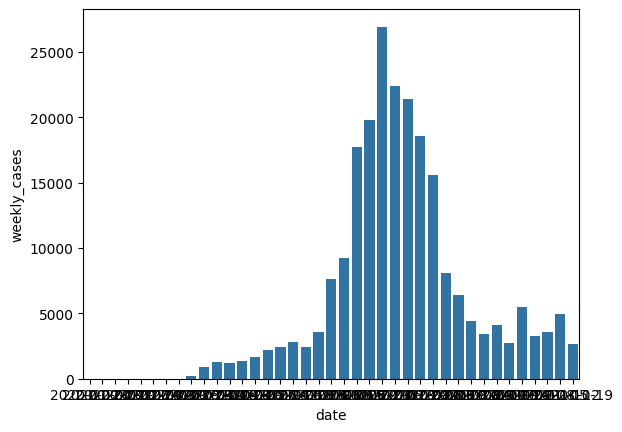

In [ ]:
# Make barplot using seaborn
# The x-axis is a mess but data look right based on what we know about Covid in AZ
import seaborn as sns
sns.barplot(x = 'date', y = 'weekly_cases', data = az_data)

## Transforms - Making a key

### Making our date string

First we'll use our basic wrangling skills to take our date column and convert it back to a string with `.astype(str)`. We'll call the new column 'week_start'.

In [ ]:
# Convert to string and check
covid_grouped['week_start'] = covid_grouped['date'].astype(str)
covid_grouped.dtypes

state                    object
date             datetime64[ns]
weekly_cases              int64
weekly_deaths             int64
week_start               object
dtype: object

Let's do this operation on 'week_start'.

In [ ]:
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths,week_start
0,Alabama,2020-03-16,19,0,2020-03-16
1,Alabama,2020-03-23,151,0,2020-03-23
2,Alabama,2020-03-30,707,11,2020-03-30
3,Alabama,2020-04-06,1048,42,2020-04-06
4,Alabama,2020-04-13,1797,51,2020-04-13


In [ ]:
# Remove dash from week start
covid_grouped['week_start'] = covid_grouped['week_start'].str.replace('-', '')
covid_grouped.head()

,state,date,weekly_cases,weekly_deaths,week_start
0,Alabama,2020-03-16,19,0,20200316
1,Alabama,2020-03-23,151,0,20200323
2,Alabama,2020-03-30,707,11,20200330
3,Alabama,2020-04-06,1048,42,20200406
4,Alabama,2020-04-13,1797,51,20200413


### Making our state names into numeric factors


In [ ]:
# If you want to test it out
states = ['washington', 'washington', 'arizona', 'california']
pd.factorize(states)

(array([0, 0, 1, 2]),
 array(['washington', 'arizona', 'california'], dtype=object))

Let's apply factorize to create a new column called 'state_id'.

In [ ]:
covid_grouped['state_id'] = pd.factorize(covid_grouped['state'])[0].astype(str)
covid_grouped

,state,date,weekly_cases,weekly_deaths,week_start,state_id
0,Alabama,2020-03-16,19,0,20200316,0
1,Alabama,2020-03-23,151,0,20200323,0
2,Alabama,2020-03-30,707,11,20200330,0
3,Alabama,2020-04-06,1048,42,20200406,0
4,Alabama,2020-04-13,1797,51,20200413,0
...,...,...,...,...,...,...
1765,Wyoming,2020-09-21,552,3,20200921,53
1766,Wyoming,2020-09-28,810,1,20200928,53
1767,Wyoming,2020-10-05,875,3,20201005,53
1768,Wyoming,2020-10-12,1173,1,20201012,53


In [ ]:
# Add strings
covid_grouped['wk_st_id'] = covid_grouped['state_id'] + covid_grouped['week_start']
covid_grouped

,state,date,weekly_cases,weekly_deaths,week_start,state_id,wk_st_id
0,Alabama,2020-03-16,19,0,20200316,0,020200316
1,Alabama,2020-03-23,151,0,20200323,0,020200323
2,Alabama,2020-03-30,707,11,20200330,0,020200330
3,Alabama,2020-04-06,1048,42,20200406,0,020200406
4,Alabama,2020-04-13,1797,51,20200413,0,020200413
...,...,...,...,...,...,...,...
1765,Wyoming,2020-09-21,552,3,20200921,53,5320200921
1766,Wyoming,2020-09-28,810,1,20200928,53,5320200928
1767,Wyoming,2020-10-05,875,3,20201005,53,5320201005
1768,Wyoming,2020-10-12,1173,1,20201012,53,5320201012


## Making our table of state keys

In [ ]:
# Make states by selecting columns and dropping duplicates
states = covid_grouped[['state_id', 'state']].drop_duplicates()
states.head()

,state_id,state
0,0,Alabama
32,1,Alaska
64,2,Arizona
103,3,Arkansas
135,4,California


Now we'll drop 'week_start' and 'state' from `covid_grouped` as those columns are redundant. The week start is just the 'date' column which we'll keep. And we have a 'state_id' column so we don't need the state name.

`.drop()` is useful here.

In [ ]:
# Drop columns
covid_grouped = covid_grouped.drop(columns=['week_start', 'state'])
covid_grouped.head()

,date,weekly_cases,weekly_deaths,state_id,wk_st_id
0,2020-03-16,19,0,0,020200316
1,2020-03-23,151,0,0,020200323
2,2020-03-30,707,11,0,020200330
3,2020-04-06,1048,42,0,020200406
4,2020-04-13,1797,51,0,020200413


## Pushing to our SQL database

Alright, let's go and push our two tables to the database

Pushing data to a database has two steps.

In [ ]:
!pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.9 MB/s eta 0:00:00


### Define SQL functions

In [ ]:
import mysql.connector
mysql_address =""
mysql_username =""
mysql_password =""
mysql_database =""

def get_conn_cur():
    cnx = mysql.connector.connect(user=mysql_username, password=mysql_password,
          host=mysql_address,
          database=mysql_database, port='3306');
    return (cnx, cnx.cursor())

In [ ]:
def run_query(query_string):
  conn, cur = get_conn_cur() # get connection and cursor
  cur.execute(query_string) # executing string as before
  my_data = cur.fetchall() # fetch query data as before
  result_df = pd.DataFrame(my_data, columns=cur.column_names)
  cur.close()
  conn.close()
  return result_df


def sql_head(table_name):
  conn, cur = get_conn_cur()

  #get head information
  table_rows_query = """ SELECT * FROM %s LIMIT 5; """ % table_name
  cur.execute(table_rows_query)
  my_data = cur.fetchall() # fetch results

  # Create a dataframe that combines sql table with column names and return
  df = pd.DataFrame(my_data, columns=cur.column_names)

  cur.close()
  conn.close()
  return df

## Create weekly table in database

In [ ]:
# query with wk_st_id as an integer and primary key
# date as a timestamp
# cases and deaths as intergers
# state_id as characters
tq = """CREATE TABLE coviddb_weekly_stats (
     wk_st_id INTEGER PRIMARY KEY,
     date timestamp NOT NULL ,
     weekly_cases INTEGER NOT NULL,
     weekly_deaths INTEGER NOT NULL,
     state_id VARCHAR(255) NOT NULL
     );"""

In [ ]:
# Get our connection and cursor and assign to conn and cur
conn, cur = get_conn_cur()


In [ ]:
# execute our query we wrote above
cur.execute(tq)

In [ ]:
# commit
conn.commit()

In [ ]:
# Is the table there? # All of our column names?
sql_head('coviddb_weekly_stats')

,wk_st_id,date,weekly_cases,weekly_deaths,state_id


In [ ]:
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """ALTER TABLE coviddb_weekly_stats
     MODIFY COLUMN wk_st_id BIGINT;"""
cur.execute(uq)
conn.commit()

We can run a quick query to get the datatypes. There is a query "SHOW CREATE TABLE tablename" that gets us the definition of a MySQL table

In [ ]:
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """ SHOW CREATE TABLE coviddb_weekly_stats;"""
cur.execute(uq)
cur.fetchall()

[('coviddb_weekly_stats',
  'CREATE TABLE `coviddb_weekly_stats` (\n  `wk_st_id` bigint NOT NULL,\n  `date` timestamp NOT NULL,\n  `weekly_cases` int NOT NULL,\n  `weekly_deaths` int NOT NULL,\n  `state_id` varchar(255) NOT NULL,\n  PRIMARY KEY (`wk_st_id`)\n) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci')]

## Make states table

This one should have only two columns, both with character datatypes like above. The primary key should be 'state_id'

In [ ]:
states.head()

,state_id,state
0,0,Alabama
32,1,Alaska
64,2,Arizona
103,3,Arkansas
135,4,California


In [ ]:
# Make your states table
conn, cur = get_conn_cur()
cur = conn.cursor()
tq = """CREATE TABLE coviddb_states (
     state_id BIGINT PRIMARY KEY,
     state VARCHAR(255) NOT NULL
     );"""
cur.execute(tq)
conn.commit()
conn.close()

We can use SHOW TABLES query to see the list of tables

In [ ]:
# check that the table is tere
run_query("SHOW TABLES")

,Tables_in_myista322dbs
0,coviddb_states
1,coviddb_weekly_stats
2,profsdb_profs


In [ ]:
# Check that the column names are there
sql_head('coviddb_states')

,state_id,state


In [ ]:
# Might as well check the datatypes
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """ SHOW CREATE TABLE coviddb_states"""
cur.execute(uq)
print(cur.fetchall())
conn.close()

[('coviddb_states', 'CREATE TABLE `coviddb_states` (\n  `state_id` bigint NOT NULL,\n  `state` varchar(255) NOT NULL,\n  PRIMARY KEY (`state_id`)\n) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci')]


## Putting information in the database

First, we need to reorder our columns in the dataframe to match the column order of the database.

In [ ]:
conn, cur = get_conn_cur()
cur = conn.cursor()
uq = """ SHOW CREATE TABLE coviddb_weekly_stats"""
cur.execute(uq)
print(cur.fetchall())
conn.close()

[('coviddb_weekly_stats', 'CREATE TABLE `coviddb_weekly_stats` (\n  `wk_st_id` bigint NOT NULL,\n  `date` timestamp NOT NULL,\n  `weekly_cases` int NOT NULL,\n  `weekly_deaths` int NOT NULL,\n  `state_id` varchar(255) NOT NULL,\n  PRIMARY KEY (`wk_st_id`)\n) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci')]


In [ ]:
# Reorder covid_grouped to match
covid_grouped = covid_grouped[['wk_st_id', 'date', 'weekly_cases', 'weekly_deaths', 'state_id']]
covid_grouped.head()

,wk_st_id,date,weekly_cases,weekly_deaths,state_id
0,020200316,2020-03-16,19,0,0
1,020200323,2020-03-23,151,0,0
2,020200330,2020-03-30,707,11,0
3,020200406,2020-04-06,1048,42,0
4,020200413,2020-04-13,1797,51,0


In [ ]:
import numpy as np
data_tups = [tuple(x) for x in covid_grouped.to_numpy()]

What's in `data_tups`? Let's look at the 3rd position.

In [ ]:
# Check out an example
data_tups[2]

('020200330', Timestamp('2020-03-30 00:00:00'), 707, 11, '0')

Great, so now that's in a format that's ready for VALUES part of our INSERT string. Now we can write our insert string that will take those values.

In [ ]:
iq = """INSERT INTO coviddb_weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id) VALUES(%s, %s, %s, %s, %s);"""
iq

'INSERT INTO coviddb_weekly_stats(wk_st_id,date,weekly_cases,weekly_deaths,state_id) VALUES(%s, %s, %s, %s, %s);'

### Finally pushing data to the database

Now we can finally use `executemany() to push our database.

In [ ]:
# Upload data
conn, cur = get_conn_cur()
cur.executemany(iq, data_tups)
conn.commit()
conn.close()

In [ ]:
sq = """ SELECT COUNT(DISTINCT(wk_st_id)) FROM coviddb_weekly_stats
     LIMIT 5;"""
run_query(sq)

,COUNT(DISTINCT(wk_st_id))
0,1770


### Add data to states table

In [ ]:
import numpy as np

In [ ]:
#get the column names
cols = states.columns

In [ ]:
data_tups = [tuple(x) for x in states.to_numpy()]

In [ ]:
# new insert query
iq = """INSERT INTO coviddb_states(state_id,state) VALUES(%s, %s);"""

In [ ]:
# Upload data
conn, cur = get_conn_cur()
cur.executemany(iq, data_tups)
conn.commit()
conn.close()

## Run some test queries!

In [ ]:
# Test query to look at the first five rows of states
sq = """ SELECT * FROM coviddb_states
     LIMIT 5;"""
run_query(sq)

,state_id,state
0,0,Alabama
1,1,Alaska
2,2,Arizona
3,3,Arkansas
4,4,California


In [ ]:
# And weekly_stats
sq = """ SELECT * FROM coviddb_weekly_stats
     LIMIT 5;"""
run_query(sq)

,wk_st_id,date,weekly_cases,weekly_deaths,state_id
0,20200316,2020-03-16,19,0,0
1,20200323,2020-03-23,151,0,0
2,20200330,2020-03-30,707,11,0
3,20200406,2020-04-06,1048,42,0
4,20200413,2020-04-13,1797,51,0


In [ ]:
# Do a subquery getting just weekly stats where the state is 'Arizona'
sq = """ SELECT * FROM coviddb_weekly_stats
     WHERE state_id = (SELECT state_id FROM coviddb_states WHERE state = 'Arizona')
     LIMIT 5;"""
run_query(sq)

,wk_st_id,date,weekly_cases,weekly_deaths,state_id
0,220200127,2020-01-27,0,0,2
1,220200203,2020-02-03,0,0,2
2,220200210,2020-02-10,0,0,2
3,220200217,2020-02-17,0,0,2
4,220200224,2020-02-24,0,0,2
